In [ ]:
!pip install powerlaw==1.4.6

In [2]:
from scipy.optimize import curve_fit
from sklearn import preprocessing
import networkx as nx
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
import itertools
import collections
import powerlaw
from nltk import bigrams
from nltk.util import ngrams
import os
import glob
import plotly.express as px
import plotly.graph_objs as go
from nltk.corpus import stopwords
import string
import math
from sklearn.model_selection import train_test_split
# use glob to get all the csv files in the folder



In [ ]:
df = pd.read_csv('df_tutti_1.csv')
df.shape

# Text preparation

In [ ]:
import string
punctuation=string.punctuation.replace('+', '')
def remove_punct(text):
    text  = "".join([char for char in text if char not in punctuation])
    return text

df['Tweet_punct'] = df['renderedContent'].apply(lambda x: remove_punct(x) )

df['Tweet_punct']

In [ ]:
# words_in_tweet
words_in_tweet = [tweet.lower().split() for tweet in df['Tweet_punct']]

In [ ]:
#Removing stop-word
stop_words = set(stopwords.words('italian'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

#create a unique list from all tweets, and set to dataframe
word= [item for sublist in tweets_nsw for item in sublist]
words=pd.DataFrame()
words['word']=word
words['count'] = df.apply(lambda _: '', axis=1)
tweets_nsw

In [ ]:
#Create a ranking for the words
frequ=FreqDist(word)
rank=pd.DataFrame(frequ.items(), columns=['Word', 'Count'])
rank=rank.set_index('Word')
rank.sort_values(by=['Count'])

In [ ]:
df['renderedContent']=tweets_nsw

# Create user and mentioned user lists

In [ ]:
user=[]
for i in range(0, len(df['user'])):
    c=df['user'][i].split("'")
    user.append(c[3])

In [ ]:
use = np.array(user) 
unique_user = np.unique(use)
len(unique_user)

In [ ]:
men_user=[[] for _ in range(0,len(df['mentionedUsers']))]

for i in range(0,len(df['mentionedUsers'])):
    if isinstance(df['mentionedUsers'][i],float):
        men_user[i].append('nan')
    else:
        v=df['mentionedUsers'][i].split("{")
        v.remove(v[0])
        if len(v)>1:
            for j in range(0, len(v)-1):
                d=v[j].split("'")
                men_user[i].append(d[3])
        elif len(v)==1:
            d=v[0].split("'")
            men_user[i].append(d[3])
    
    

In [ ]:
df.drop(df.columns.difference(['renderedContent']), axis=1, inplace=True)

In [ ]:
df['user']=user
df['men_user']=men_user

# Build the Network

In [ ]:
# Create network plot
G = nx.Graph()

# Create connections between nodes
for k ,v ,m in zip(df['user'].items(),df['men_user'].items(),df['renderedContent'].items()):
    for i in range(0, len(v[1])):
        if v[1][i]=='nan':pass
        elif G.has_edge(k[1], v[1][i]):
            G.edges[k[1],v[1][i]]['tweet'].extend(m[1])
        else:  
            G.add_edge(k[1], v[1][i], tweet=m[1])        

(G.number_of_nodes(),G.number_of_edges())

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))
(G.number_of_nodes(),G.number_of_edges(),nx.density(G))

In [ ]:
nx.write_edgelist(G, "elect_dict.edgelist")

C:\Users\emanu\AppData\Local\Temp\ipykernel_11464\718644843.py:15: RuntimeWarning: divide by zero encountered in log
  y = np.log(hist)


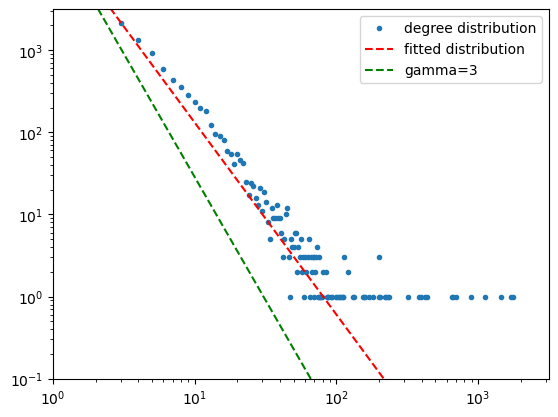

Gamma=2.3376779987544034


In [139]:
k = nx.degree_histogram(G)
sig=np.array(k[1:])


# define the function to fit
def expfunc(x, a , b):
    return a*pow(x,-b)

# bin the degree distribution
bins = np.arange(len(k))
hist = nx.degree_histogram(G)

# fit the logarithm of the degree distribution to a linear function
x = bins[1:]
y = np.log(hist)

popt, pcov = curve_fit(expfunc, x, k[1:], sigma=(sig/1)+2, absolute_sigma=True)

# plot the degree distribution and the fitted distribution on a logarithmic scale
plt.plot(range(0, len(hist)), hist,'.',label='degree distribution')
plt.plot(x, expfunc(x, *popt), 'r--', label='fitted distribution')
plt.plot(x, expfunc(x, popt[0], 3.0), 'g--', label='gamma=3')
plt.legend()
plt.ylim( (10**-1,10**3.5) )
plt.xlim( (10**0,10**3.5) )
plt.xscale('log')
plt.yscale('log')
plt.show()

# print the estimated value of b
print(f"Gamma={popt[1]}")

In [ ]:
k = nx.degree_histogram(G)
sig=np.array(k[1:])


# define the function to fit
def expfunc(x, a , b):
    return a*pow(x,-b)

# bin the degree distribution
bins = np.arange(len(k))
hist = nx.degree_histogram(G)

# fit the logarithm of the degree distribution to a linear function
x = bins[1:]
y = np.log(hist)

popt, pcov = curve_fit(expfunc, x, k[1:], sigma=sig+10, absolute_sigma=True) 
#NB:what we are going to use as sigma?

# plot the degree distribution and the fitted distribution on a logarithmic scale
plt.plot(range(0, len(hist)), hist,'.',label='degree distribution')
plt.plot(x, expfunc(x, *popt), 'r--', label='fitted distribution')
plt.plot(x, expfunc(x, popt[0], 3.0), 'g--', label='gamma=3')
plt.legend()
plt.ylim( (10**-1,10**3.5) )
plt.xlim( (10**0,10**3.5) )
plt.xscale('log')
plt.yscale('log')
plt.show()

# print the estimated value of b
print(f"Gamma={popt[1]}")